<a href="https://colab.research.google.com/github/marcosmedvescig/thesis_survival_models_for_predicting_churn/blob/master/model_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Tuning

## Install libraries

Note: After installing the libraries for the first time restart the runtime for the new versions of the library to be loaded.

In [1]:
## Install libraries
!pip install pysurvival=='0.1.2'
!pip install scikit-survival=='0.13.1'
!pip install osqp=='0.5.0'

     |████████████████████████████████| 4.8MB 4.7MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3775005 sha256=27357c505a17e6e2302bb5f2e730b236d740525d89ff456704d1976bf569da76
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=783cbc0e87018837d032f1b3ef8c4652e3b95aa9434c23c6f11f60e80420e879
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 1.8MB 5.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 30.5MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.13.1-cp36-cp36m-linux_x86_64.whl size=4119272 sha256=04ad9

## Custom Functions

In [1]:
import numpy as np
import pandas as pd
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sksurv.metrics import cumulative_dynamic_auc

def evaluate_model(model,X_train,T_train, E_train,X_test,T_test,E_test,
                   c_index=True,ibs=True,c_auc=True):

    # c-index
    if c_index:
        from pysurvival.utils.metrics import concordance_index
        c_index = concordance_index(model, X_test, T_test, E_test)
        print('c-index: {0:5.4f}'.format(c_index))
    else:
        c_index=0

    # ibs
    if ibs:        
        from pysurvival.utils.display import integrated_brier_score
        ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=200,
                    figure_size=(20, 6.5) )
        print('IBS: {0:5.4f}'.format(ibs))
    else:
        ibs=1

    # cumulative_auc
    if c_auc:
        from sksurv.metrics import cumulative_dynamic_auc

        train = np.array([(e,t) for e,t in zip(E_train,T_train)],dtype=[('event', 'bool_'),('time','int_')])
        test = np.array([(e,t) for e,t in zip(E_test,T_test)],dtype=[('event', 'bool_'),('time','int_')])

        # auc does not support inf risk so we replace with a really large value
        risk = model.predict_risk(X_test)
        risk = np.where(risk == np.inf,100,risk)

        auc_time_list,mean_auc = cumulative_dynamic_auc(train, test, risk, [100,150,300,500], tied_tol=1e-08)
        print('AUC: {0:5.4f}'.format(mean_auc))
    else:
        mean_auc=0

    #return results
    results = pd.DataFrame({'c_index':[c_index],
                                'ibs':[ibs],
                                'mean_auc':[mean_auc]})
    return results

## Load Data

In [2]:
import pandas as pd
import numpy as np
import os

# Open dataset
raw_data = pd.read_csv('https://github.com/marcosmedvescig/thesis_survival_models_for_predicting_churn/raw/master/churn_data_anonymized_20200718.csv')
raw_data.rename(columns={'survival_days': 'time', 'status': 'event'},inplace=True)

raw_data.head()

,store_id,time,event,country,max_segment,creation_platform,products_created,admin_visits,source,seller_probability,tx,gmv_usd
0,1842269723731683560,261,1,A,B,A,-0.080154,-0.161978,I,1.014303,-0.042809,-0.071061
1,4773050910207726165,107,1,A,C,A,0.012447,0.566017,I,-0.214408,-0.076793,-0.092084
2,4171477716070775996,102,0,C,A,A,-0.075205,2.295003,A,-0.467481,0.602888,0.209250
3,-558102186785033374,101,1,C,C,A,-0.078033,-0.935472,A,-0.574383,-0.110777,-0.106463
4,-2987486431769169084,444,0,A,B,A,-0.063189,0.611516,I,1.614260,-0.099449,-0.103126


## Create Train, Test and Eval datasets

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Remove observations according to EDA

raw_data = raw_data[raw_data['time']>=0]
raw_data = raw_data[raw_data['products_created'] <= (raw_data['products_created'].mean() + 3 * raw_data['products_created'].std())]
raw_data = raw_data[raw_data['admin_visits'] <= (raw_data['admin_visits'].mean() + 3 * raw_data['admin_visits'].std())]
raw_data = raw_data[raw_data['tx'] <= (raw_data['tx'].mean() + 3 * raw_data['tx'].std())]
raw_data = raw_data[raw_data['gmv_usd'] <= (raw_data['gmv_usd'].mean() + 3 * raw_data['gmv_usd'].std())]

raw_data.reset_index(drop=True,inplace=True)

# Defining the features

X = pd.get_dummies(raw_data.drop(['store_id','time', 'event'], axis=1))
T = raw_data['time']
E = raw_data['event']

## Create evaluation set, 70% of the raw_data.
index_train_test, index_eval = train_test_split( range(len(raw_data)), test_size = 0.7, random_state = 2020)

# Creating the X, T and E input
X_train_test = X.loc[index_train_test].reset_index( drop = True )
X_eval  = X.loc[index_eval].reset_index( drop = True )

T_train_test = T.loc[index_train_test].reset_index( drop = True )
T_eval  = T.loc[index_eval].reset_index( drop = True )

E_train_test = E.loc[index_train_test].reset_index( drop = True )
E_eval  = E.loc[index_eval].reset_index( drop = True )


## Create train and test set, 30% of the raw_data.
index_train, index_test = train_test_split( range(len(X_train_test)), test_size = 0.25, random_state = 2020)

# Creating the X, T and E input
X_train = X_train_test.loc[index_train].reset_index( drop = True )
X_test  = X_train_test.loc[index_test].reset_index( drop = True )

T_train = T_train_test.loc[index_train].reset_index( drop = True )
T_test  = T_train_test.loc[index_test].reset_index( drop = True )

E_train = E_train_test.loc[index_train].reset_index( drop = True )
E_test  = E_train_test.loc[index_test].reset_index( drop = True )

## Model Optimization

__Best results:__

- num_trees:        50
- max_depth:       20
- min_node_size:     5

FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth5 - min_node_size:5
c-index: 0.7615


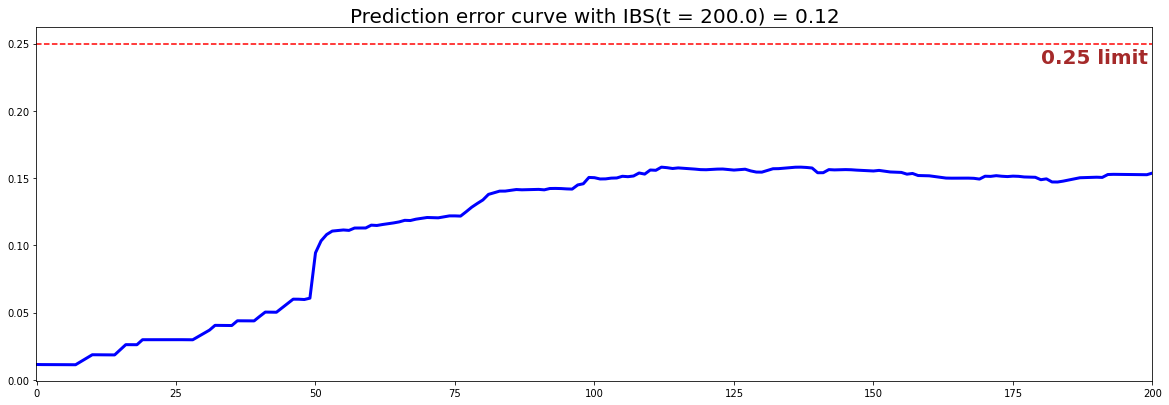

IBS: 0.1166
AUC: 0.8402
FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth5 - min_node_size:10
c-index: 0.7565


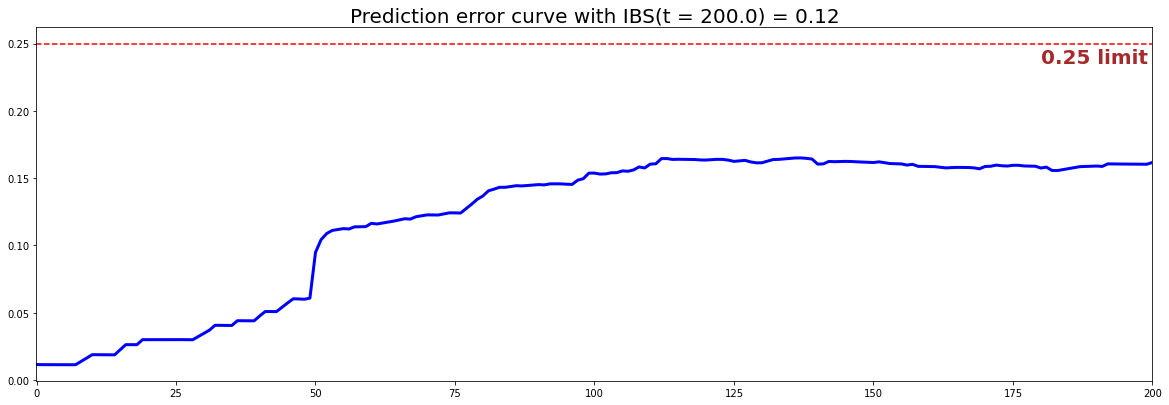

IBS: 0.1208
AUC: 0.8405
FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth5 - min_node_size:20
c-index: 0.7486


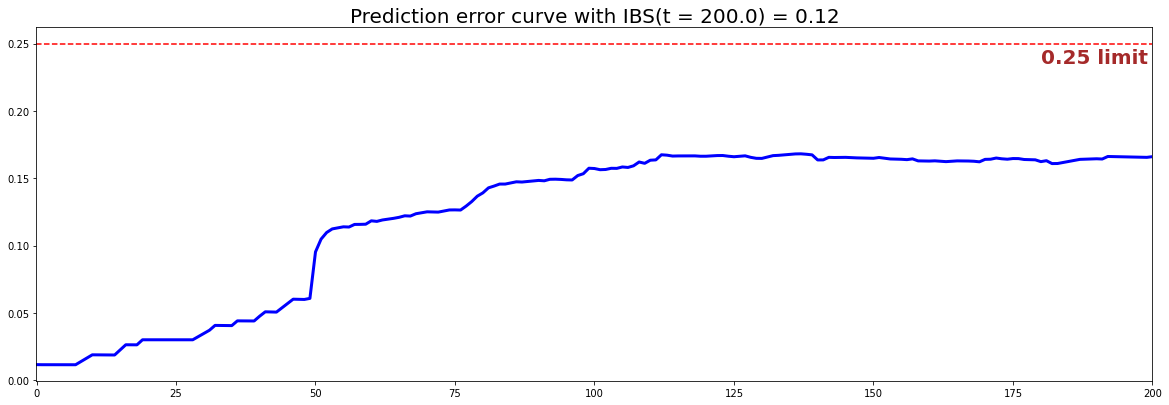

IBS: 0.1233
AUC: 0.8308
FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth10 - min_node_size:5
c-index: 0.7591


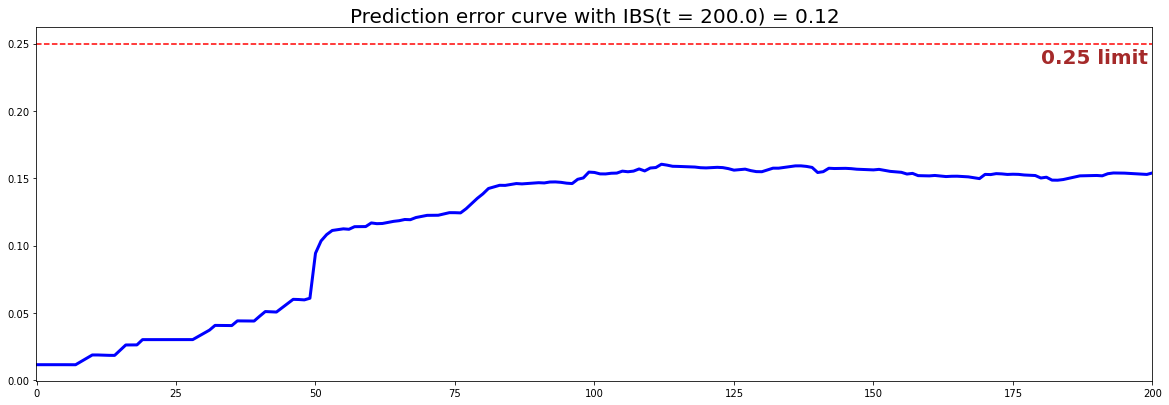

IBS: 0.1181
AUC: 0.8316
FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth10 - min_node_size:10
c-index: 0.7543


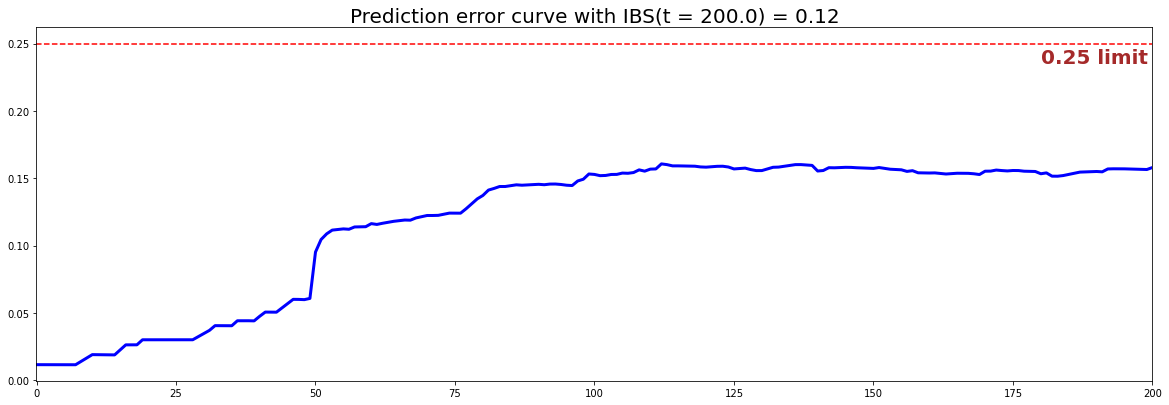

IBS: 0.1187
AUC: 0.8348
FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth10 - min_node_size:20
c-index: 0.7523


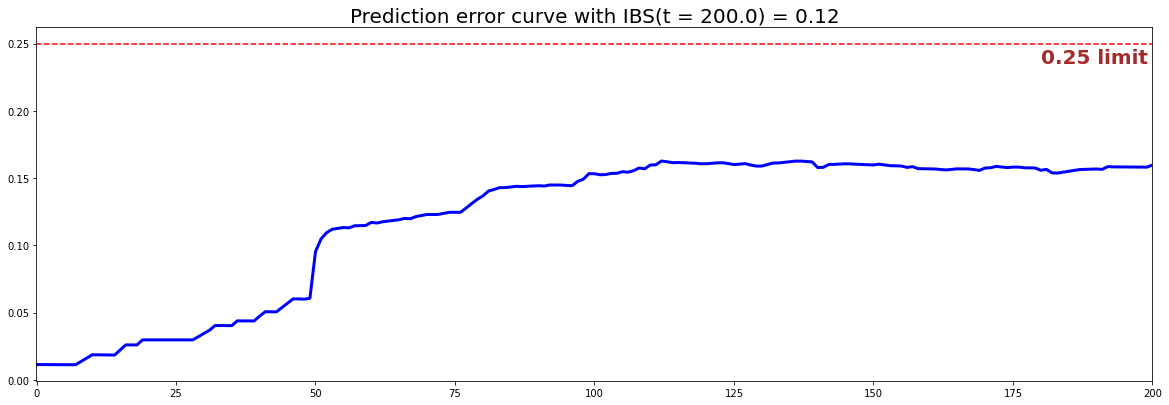

IBS: 0.1198
AUC: 0.8324
FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth20 - min_node_size:5
c-index: 0.7580


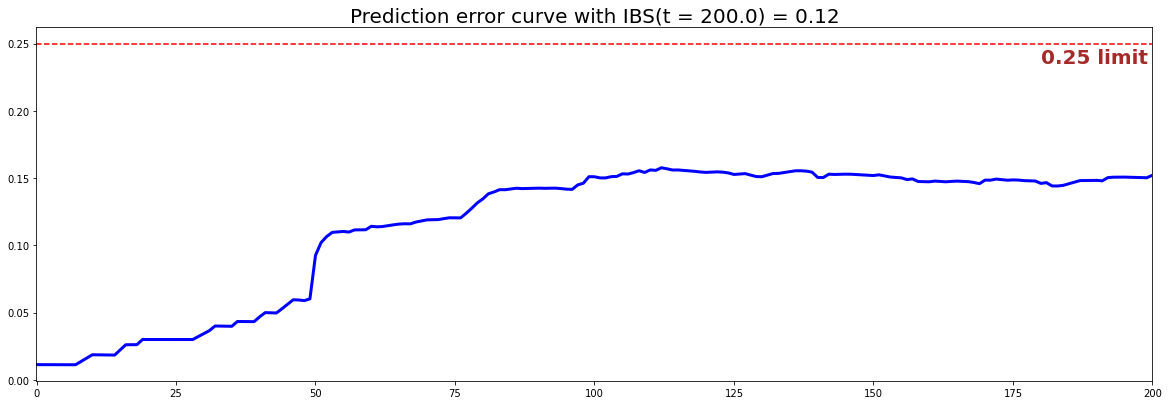

IBS: 0.1154
AUC: 0.8390
FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth20 - min_node_size:10
c-index: 0.7573


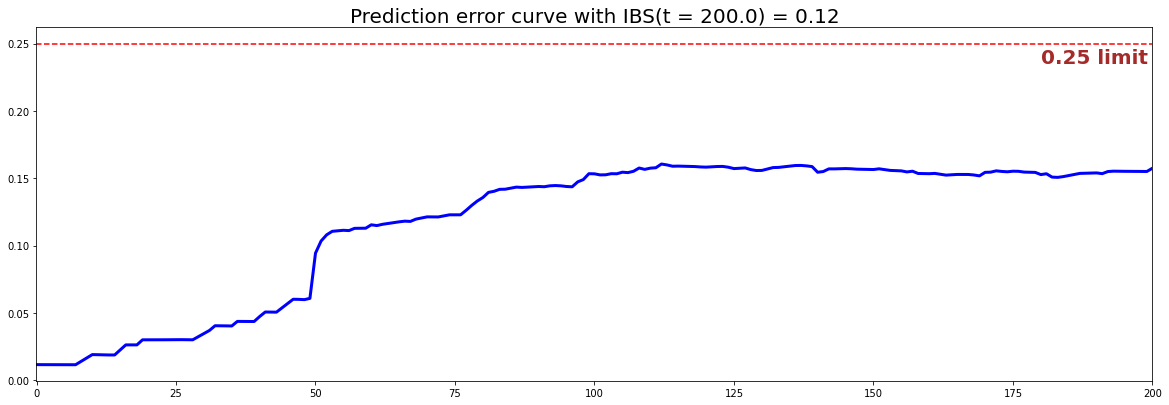

IBS: 0.1181
AUC: 0.8396
FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth20 - min_node_size:20
c-index: 0.7454


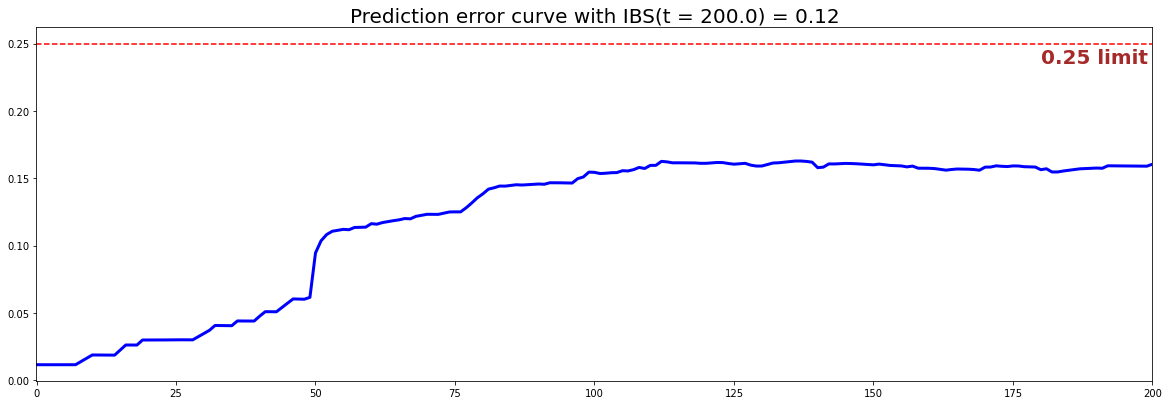

IBS: 0.1202
AUC: 0.8276
FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth5 - min_node_size:5
c-index: 0.7548


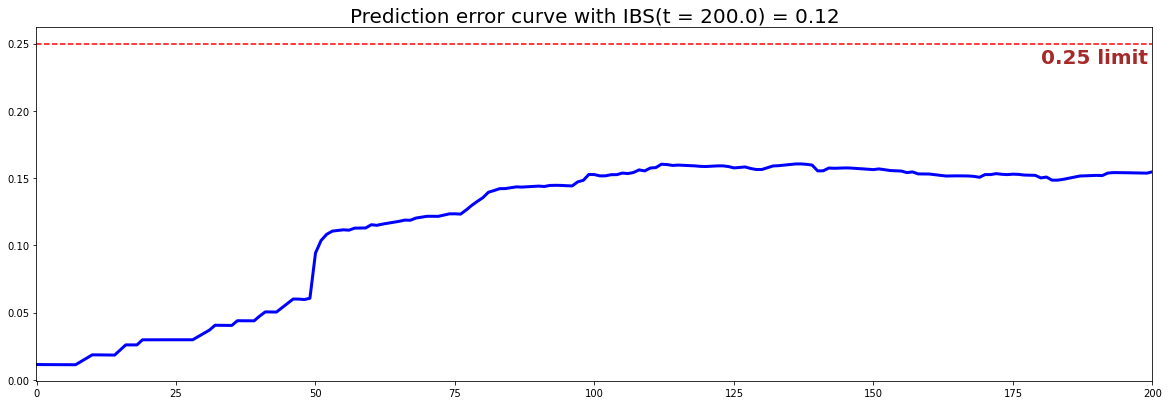

IBS: 0.1178
AUC: 0.8336
FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth5 - min_node_size:10
c-index: 0.7485


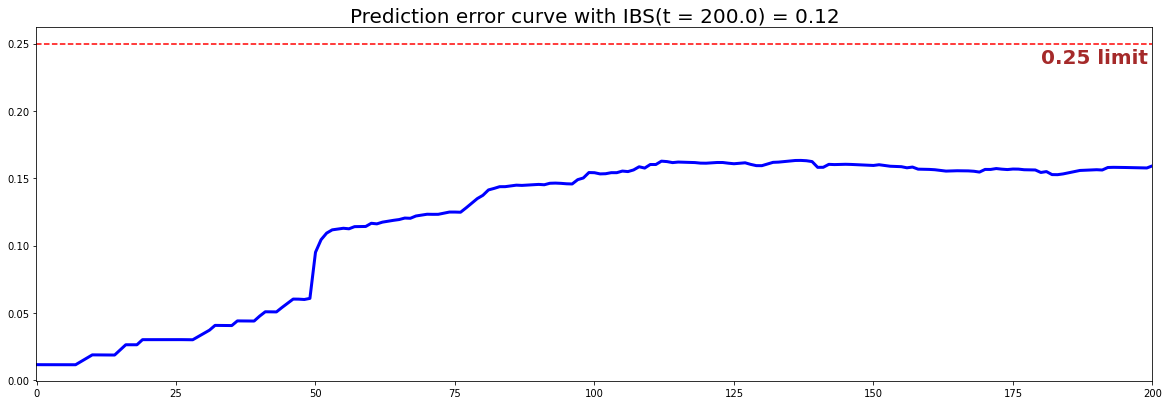

IBS: 0.1199
AUC: 0.8287
FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth5 - min_node_size:20
c-index: 0.7542


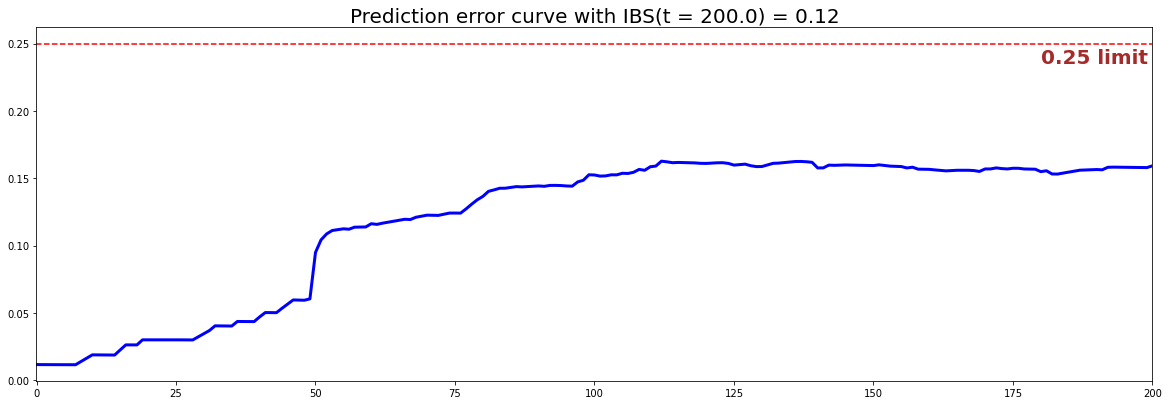

IBS: 0.1194
AUC: 0.8396
FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth10 - min_node_size:5
c-index: 0.7556


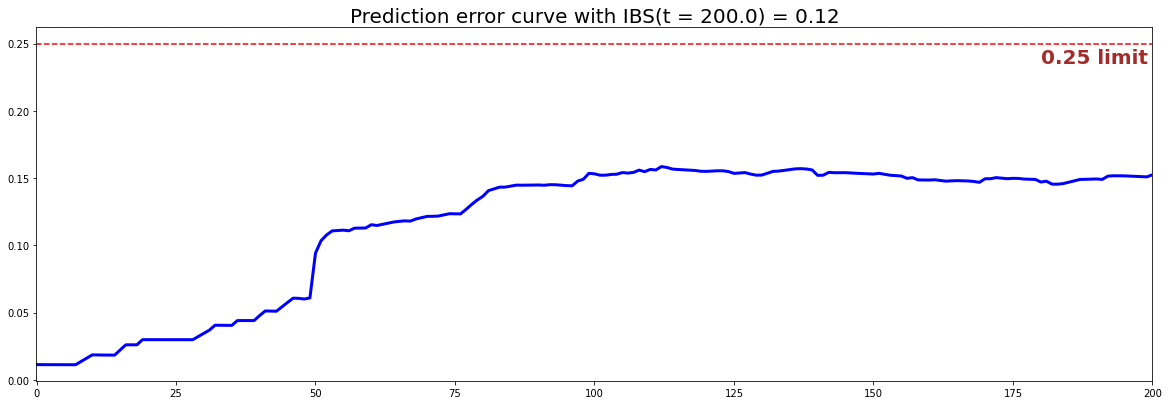

IBS: 0.1165
AUC: 0.8358
FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth10 - min_node_size:10
c-index: 0.7533


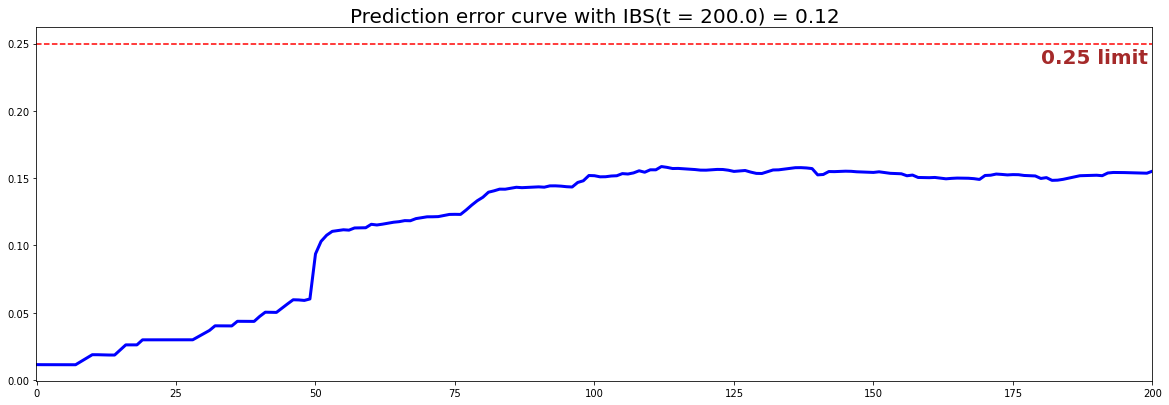

IBS: 0.1170
AUC: 0.8364
FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth10 - min_node_size:20
c-index: 0.7607


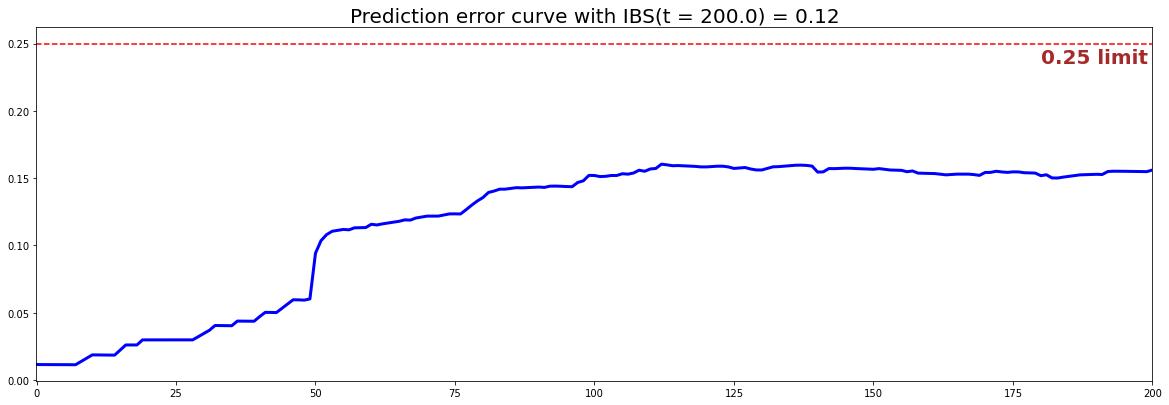

IBS: 0.1180
AUC: 0.8409
FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth20 - min_node_size:5
c-index: 0.7573


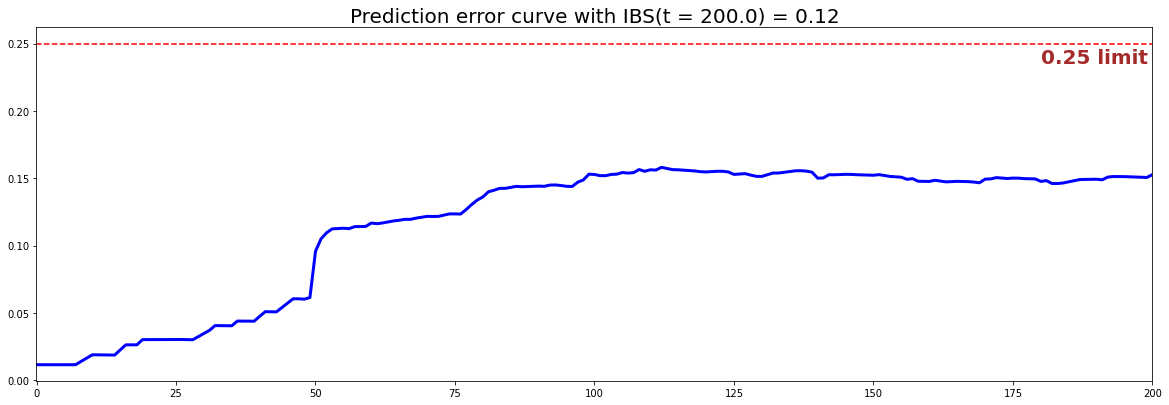

IBS: 0.1163
AUC: 0.8360
FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth20 - min_node_size:10
c-index: 0.7503


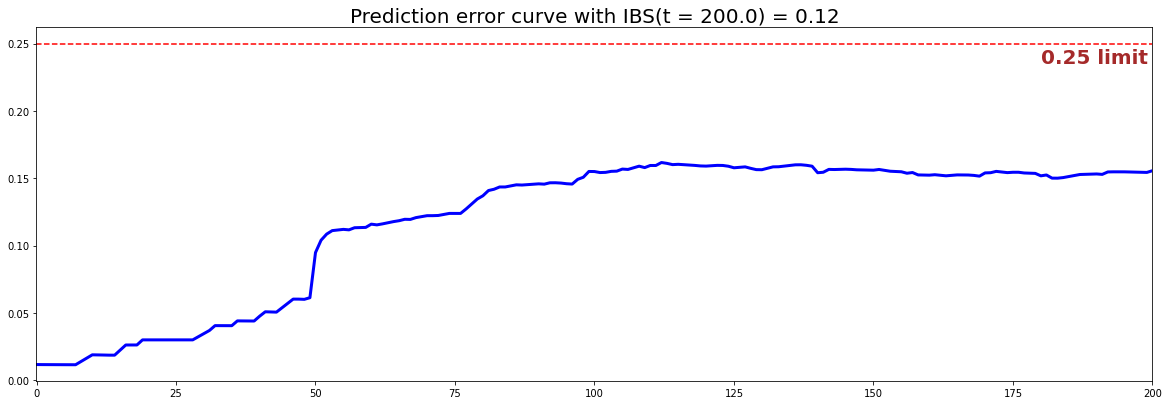

IBS: 0.1184
AUC: 0.8316
FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth20 - min_node_size:20
c-index: 0.7557


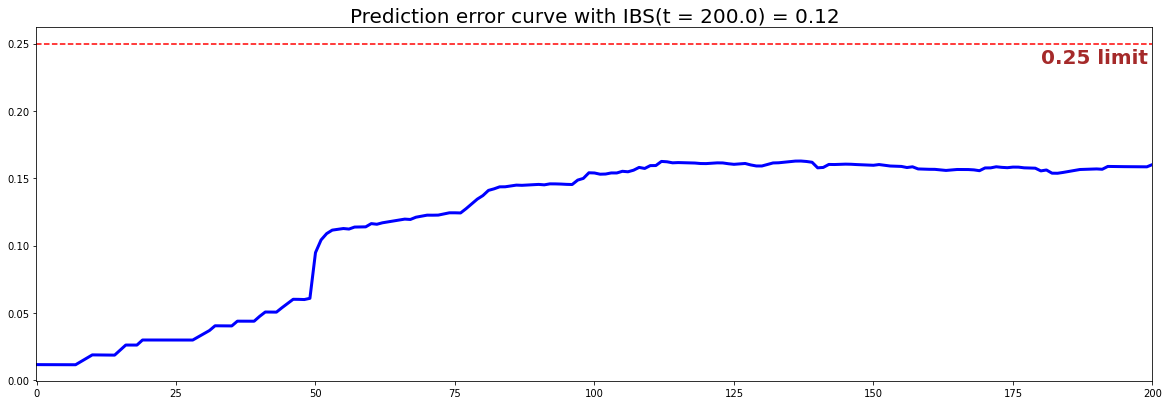

IBS: 0.1198
AUC: 0.8391
FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth5 - min_node_size:5
c-index: 0.7530


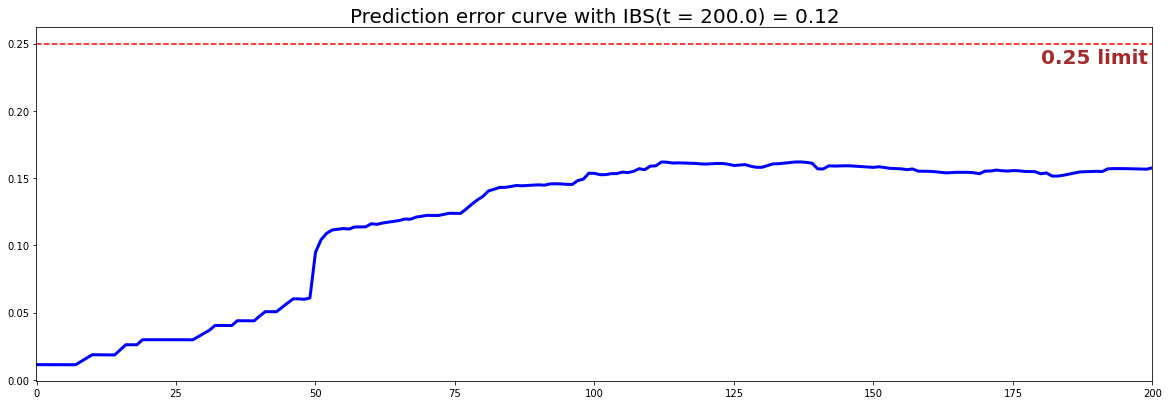

IBS: 0.1191
AUC: 0.8329
FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth5 - min_node_size:10
c-index: 0.7521


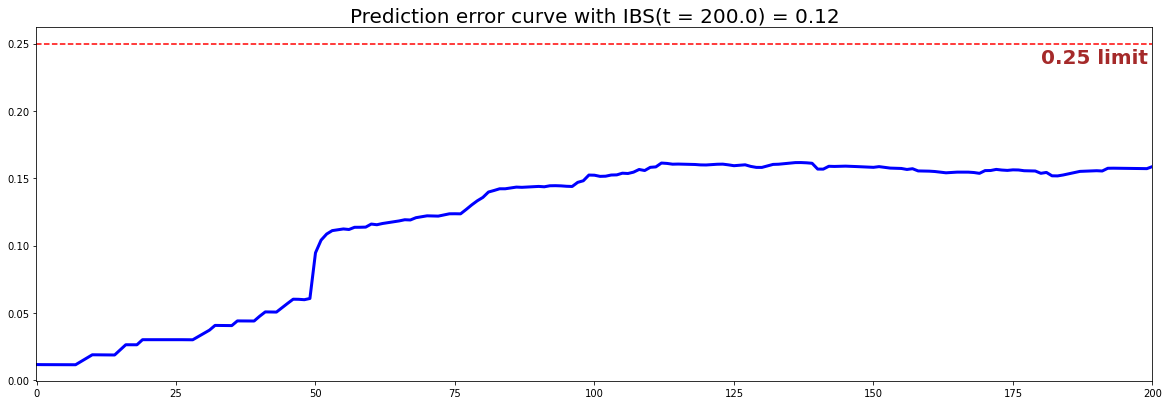

IBS: 0.1189
AUC: 0.8335
FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth5 - min_node_size:20
c-index: 0.7521


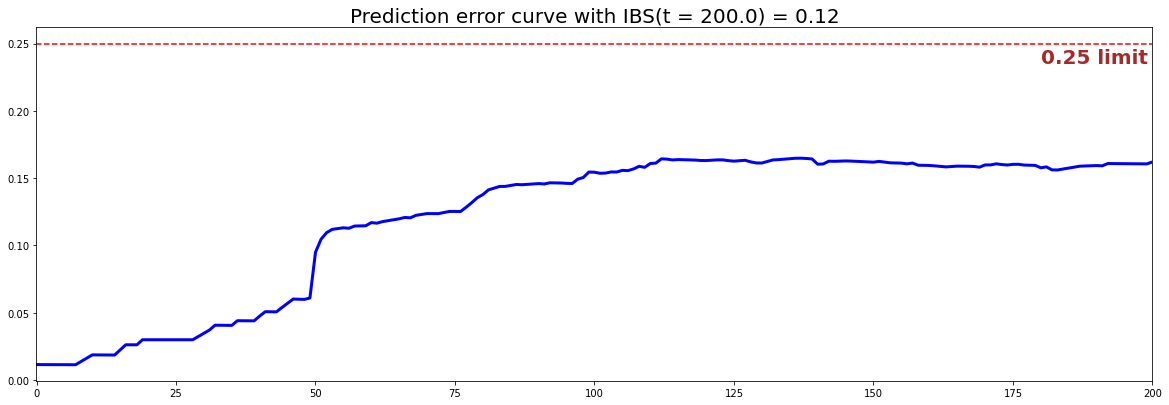

IBS: 0.1211
AUC: 0.8348
FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth10 - min_node_size:5
c-index: 0.7542


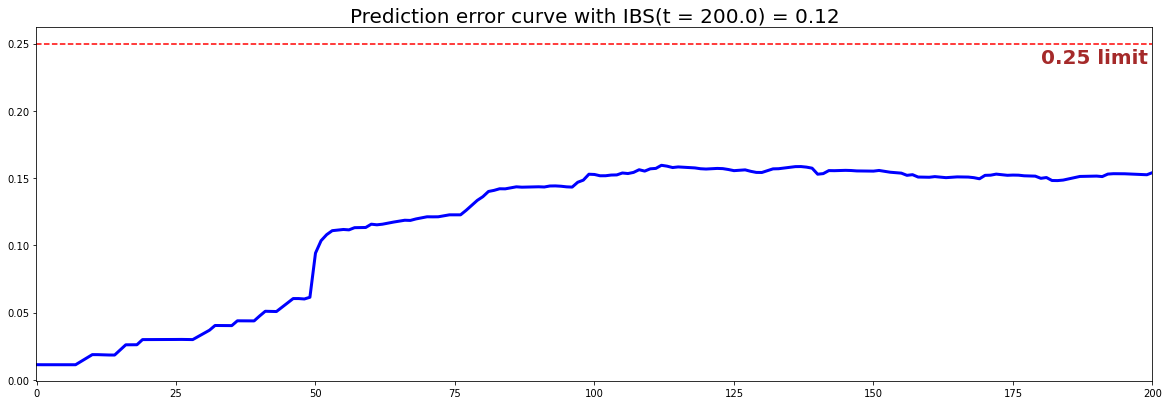

IBS: 0.1172
AUC: 0.8364
FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth10 - min_node_size:10
c-index: 0.7533


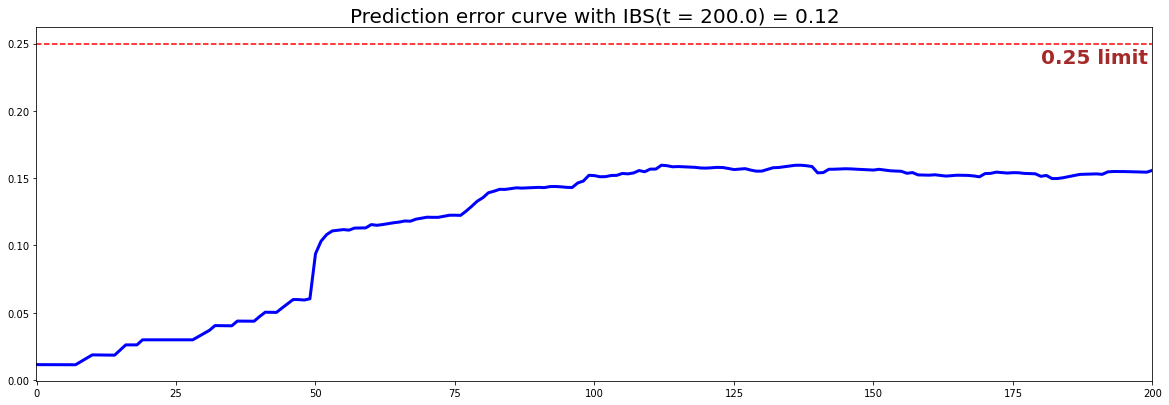

IBS: 0.1176
AUC: 0.8356
FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth10 - min_node_size:20
c-index: 0.7549


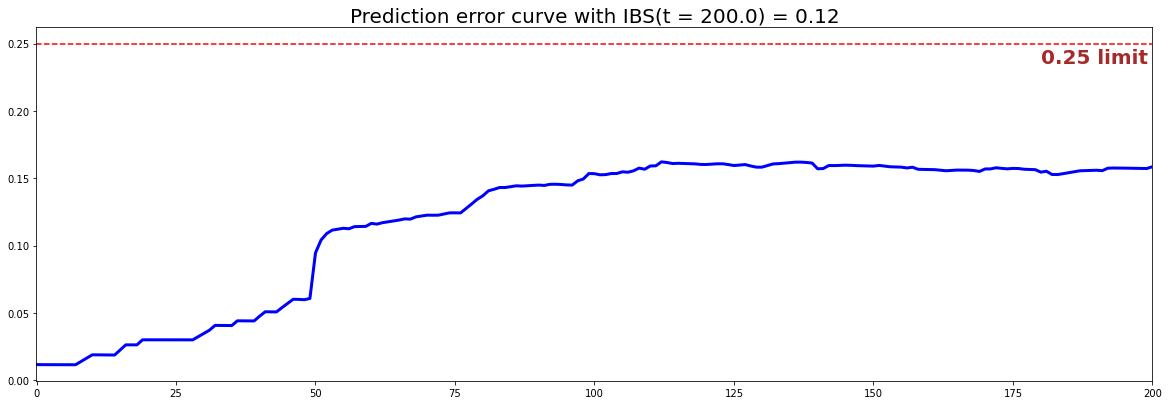

IBS: 0.1195
AUC: 0.8380
FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth20 - min_node_size:5
c-index: 0.7574


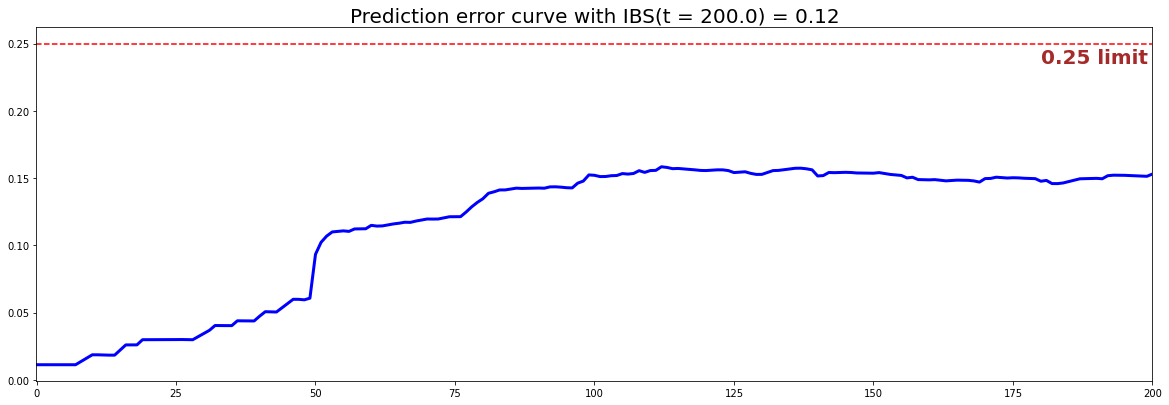

IBS: 0.1162
AUC: 0.8376
FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth20 - min_node_size:10
c-index: 0.7525


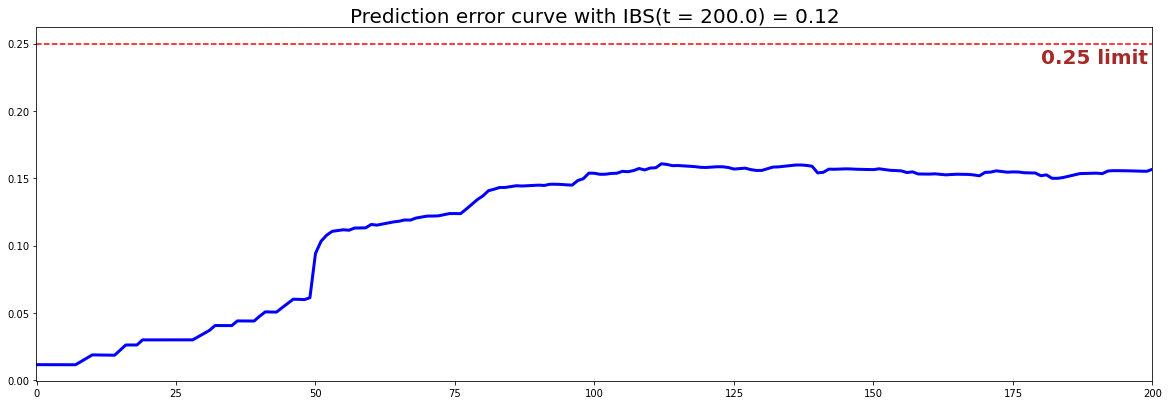

IBS: 0.1182
AUC: 0.8326
FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth20 - min_node_size:20
c-index: 0.7541


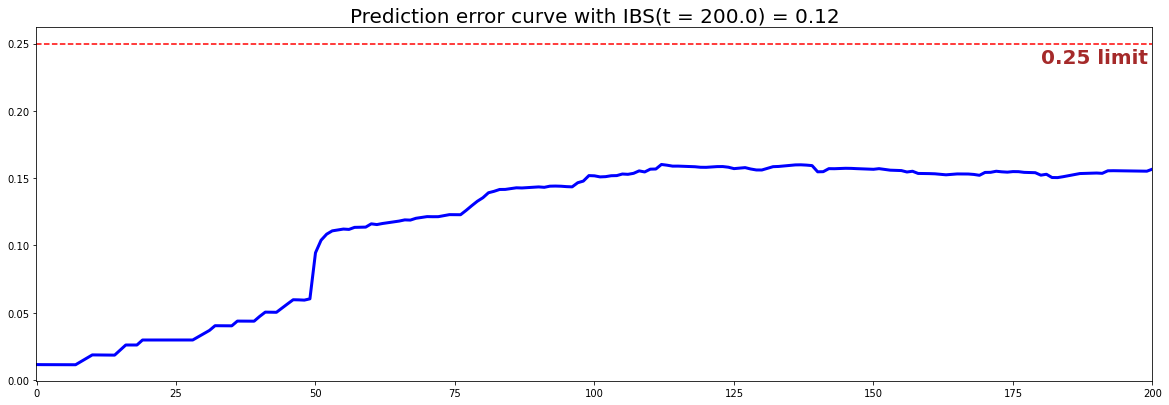

IBS: 0.1180
AUC: 0.8388


In [4]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import pandas as pd
import numpy as np

# Create empty dataframe for storing the results
results = pd.DataFrame({'c_index':[0.75],
                    'mean_auc':[0.84],
                    'ibs':[0.12],
                    'num_trees':[50],
                    'max_depth':[5],
                    'min_node_size':[20]})

# Test num_trees
for num_trees in [50,100,200]:
  for max_depth in [5,10,20]:
    for min_node_size in [5,10,20]:
           
      print('FIT MODEL WITH PARAMETERS')
      print('num_trees:{} - max_depth{} - min_node_size:{}'.format(num_trees,max_depth,min_node_size))

      ## Build the model
      rsf = RandomSurvivalForestModel(num_trees=num_trees)
      rsf.fit(X_train, T_train, E_train,
              max_features="sqrt", max_depth=max_depth, min_node_size=min_node_size)

      ## Evaluate model
      tmp_results = evaluate_model(rsf,X_train,T_train,E_train,X_test,T_test,E_test)
      tmp_results['num_trees'] = [num_trees]
      tmp_results['max_depth'] = [max_depth]
      tmp_results['min_node_size'] = [min_node_size]  
      results = pd.concat([results, tmp_results], ignore_index=True)

In [7]:
results.round(3).head(100)

,c_index,mean_auc,ibs,num_trees,max_depth,min_node_size
0,0.750,0.840,0.120,50,5,20
1,0.762,0.840,0.117,50,5,5
2,0.757,0.841,0.121,50,5,10
3,0.749,0.831,0.123,50,5,20
4,0.759,0.832,0.118,50,10,5
5,0.754,0.835,0.119,50,10,10
6,0.752,0.832,0.120,50,10,20
7,0.758,0.839,0.115,50,20,5
8,0.757,0.840,0.118,50,20,10
9,0.745,0.828,0.120,50,20,20


In [6]:
print('max c_index is on line:{}'.format(results['c_index'].idxmax()))
print('max mean_auc is on line:{}'.format(results['mean_auc'].idxmax()))
print('min ibs is on line:{}'.format(results['ibs'].idxmin()))

max c_index is on line:1
max mean_auc is on line:15
min ibs is on line:7


In [8]:
results.iloc[1]

c_index           0.761524
mean_auc          0.840169
ibs               0.116648
num_trees        50.000000
max_depth         5.000000
min_node_size     5.000000
Name: 1, dtype: float64